## 1. Import bibliotek
W folderze `src` znajdują się pomocnicze moduły. Obiekty, które są użyte w tym skrypcie:
1. Klasa `CleanedDataReader`:
   - Służy do wczytywania i czyszczenia danych z plików CSV
   - Wykrywa i naprawia wadliwe linie w danych
   - Posiada metody do konwersji danych do formatu pandas DataFrame

2. Funkcje do wizualizacji danych:
    - `plot_hists()` - tworzy histogramy dla wybranych kolumn
    - `freq_over_attribute_plot()` - generuje wykres częstotliwości szkód względem wybranego atrybutu
    - `corr_plot()` - tworzy macierz korelacji w formie heatmapy
    - `scatter_plot()` - tworzy zaawansowany wykres punktowy z opcjonalną linią trendu
    - `plot_heatmap()` - generuje heatmapę dla zadanych parametrów

3. Funkcje pomocnicze:
    - `count_nulls` - zwraca liczbę wierszy z wartością `NULL`(`NaN`)
    - `get_null_record` - zwraca rekordy z df, które mają wartość `NULL`(`NaN`)
    - `count_duplicates` - zlicza zduplikowane rekordy w ramach podanego wymiaru

In [4]:
# włącza tryb inline dla wykresów matplotlib (wyświetlanie w notebooku)
%matplotlib inline
# ładuje rozszerzenie autoreload
%load_ext autoreload
# automatycznie przeładowuje zmodyfikowane moduły przed wykonaniem kodu
%autoreload 2

# Importy z bibliotek standardowych
import warnings

# Importy z bibliotek zewnętrznych
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Importy lokalne
from src.data.datareader import CleanedDataReader
from src.data.plots import (corr_plot, freq_over_attribute_plot, plot_heatmap,
                          plot_hists, scatter_plot)
from src.data.utils import count_duplicates, count_nulls, get_null_records

# Konfiguracja
warnings.filterwarnings("ignore", module="matplotlib\\..*")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id="sekcja_wczytywanie"></a>
## 2. Wczytywanie danych
W komórce poniżej wczytujemy dane z pliku CSV za pomocą klasy CleanedDataReader. 
Klasa ta automatycznie wykryje i naprawi wadliwe linie w danych.
Metoda get_enhanced_data() zwróci nam DataFrame z wczytanymi danymi, gdzie:
- index_col=0 oznacza, że pierwsza kolumna będzie użyta jako indeks,
- wadliwe linie zostaną naprawione - **problemem są linie, w których występuje więcej elementów niż jest kolumn**,
- dane zostaną odpowiednio sformatowane - **dane zostaną wczytane pomijając puste wartości**.
- w poniższym logu widać, których wierszy dotyczy problem i jak został on rozwiązany


In [5]:
data_reader = CleanedDataReader(path='../../data/raw/claims_data.csv')
df = data_reader.get_enhanced_data(index_col=0)

Bad line:
['653', '1357.0', '1.0', '0.01', 'E', '7.0', '0.0', '41.0', '80.0', 'B12', 'Diesel', '6257.0', 'R93', '']
was converted to:
['653', '1357.0', '1.0', '0.01', 'E', '7.0', '0.0', '41.0', '80.0', 'B12', 'Diesel', '6257.0', 'R93']

Bad line:
['1435', '2967.0', '1.0', '0.64', 'B', '5.0', '0.0', '53.0', '50.0', 'B12', '', 'Regular', '68.0', 'R52']
was converted to:
['1435', '2967.0', '1.0', '0.64', 'B', '5.0', '0.0', '53.0', '50.0', 'B12', 'Regular', '68.0', 'R52']

Bad line:
['123123', '1070775.0', '0.0', '0.48', 'B', '8.0', '7.0', '42.0', '59.0', 'B2', 'Diesel', '72.0', 'R52', '']
was converted to:
['123123', '1070775.0', '0.0', '0.48', 'B', '8.0', '7.0', '42.0', '59.0', 'B2', 'Diesel', '72.0', 'R52']

Bad line:
['381011', '3043346.0', '0.0', '0.92', 'A', '4.0', '2.0', '60.0', '90.0', 'B12', '', 'Regular', '6.0', 'R72']
was converted to:
['381011', '3043346.0', '0.0', '0.92', 'A', '4.0', '2.0', '60.0', '90.0', 'B12', 'Regular', '6.0', 'R72']

Bad line:
['547534', '4138712.0', '1.0

<a id="sekcja_rozpoznanie"></a>
## 3. Zapoznanie się z danymi

**Zbiór danych zawiera informacje o polisach ubezpieczeniowych, w tym szczegóły dotyczące pojazdów (moc, wiek, marka, rodzaj paliwa), kierowców (wiek, współczynnik bonus-malus) oraz lokalizacji (region, gęstość zaludnienia). Kluczowe zmienne to liczba szkód (`ClaimNb`) oraz czas trwania polisy (`Exposure`). Dane obejmują ponad 678 tysięcy polis, z których każda jest jednoznacznie identyfikowana przez `IDpol`.**

W zbiorze danych mamy 12 kolumn. Na podstawie analizy statystyk opisowych możemy stwierdzić:

| **Zmienna**  | *Opis*                                                                                  |
|--------------|----------------------------------------------------------------------------------------|
| **IDpol**    | *Identyfikator polisy, przyjmuje wartości od 1 do 6,114,330*                          |
| **ClaimNb**  | *Liczba szkód, od 0 do 16, ze średnią 0.053*                                          |
| **Exposure** | *Czas trwania polisy w latach, od 0.003 do 2.01 roku, średnio 0.53 roku*              |
| **Area**     | *Zmienna kategoryczna z 6 unikalnymi wartościami, najczęstsza to 'C' (191,880 wystąpień)*|
| **VehPower** | *Moc pojazdu od 4 do 15, średnio 6.45*                                                 |
| **VehAge**   | *Wiek pojazdu od 0 do 100 lat, mediana 6 lat*                                         |
| **DrivAge**  | *Wiek kierowcy od 18 do 100 lat, średnio 44 lata*                                     |
| **BonusMalus**| *Współczynnik od 50 do 230, mediana 50*                                              |
| **VehBrand** | *Zmienna kategoryczna (marki pojazdów)*                                                |
| **VehGas**   | *Zmienna kategoryczna (typ paliwa)*                                                    |
| **Density**  | *Gęstość zaludnienia od 1 do 27,000, mediana 393*                                      |
| **Region**   | *Zmienna kategoryczna z 22 unikalnymi wartościami, najczęstsza to 'R24' (160,600 wystąpień)*|


In [6]:
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09,NaN,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72


In [7]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IDpol,678013.0,NaN,NaN,NaN,2621856.921071,1641782.752655,1.0,1157951.0,2272152.0,4046274.0,6114330.0
ClaimNb,678012.0,NaN,NaN,NaN,0.053245,0.240115,0.0,0.0,0.0,0.0,16.0
Exposure,678012.0,NaN,NaN,NaN,0.528749,0.364441,0.002732,0.18,0.49,0.99,2.01
Area,678012,6,C,191880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehPower,678012.0,NaN,NaN,NaN,6.454632,2.050907,4.0,5.0,6.0,7.0,15.0
VehAge,678012.0,NaN,NaN,NaN,7.044251,5.666225,0.0,2.0,6.0,11.0,100.0
DrivAge,678012.0,NaN,NaN,NaN,45.499102,14.137445,18.0,34.0,44.0,55.0,100.0
BonusMalus,678012.0,NaN,NaN,NaN,59.761506,15.636669,50.0,50.0,50.0,64.0,230.0
VehBrand,678012,11,B12,166023,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehGas,678012,2,Regular,345877,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analiza braków danych i powtarzających się danych
Wszystkie kolumny (poza `IDpol`) mają po 1 wartości `null` (`nan`). 
W kolejnych etapach konieczne będzie zrezygnowanie z tych rekordów, które mają braki w kolumnach `CLaimNb` oraz `Exposure`.

In [8]:
count_nulls(df)

,index,0
0,IDpol,0
1,ClaimNb,1
2,Exposure,1
3,Area,1
4,VehPower,1
5,VehAge,1
6,DrivAge,1
7,BonusMalus,1
8,VehBrand,1
9,VehGas,1


Rekordy, w których znajdue się co najmniej jeden `NULL` (`NaN`).

In [9]:
get_null_records(df)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
3,10.0,1.0,0.09,NaN,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
567,1185.0,NaN,0.85,C,7.0,0.0,45.0,50.0,B12,Regular,309.0,R73
32341,66563.0,0.0,0.32,C,7.0,11.0,47.0,72.0,B2,NaN,168.0,R91
45732,92374.0,0.0,1.00,A,NaN,1.0,50.0,50.0,B3,Diesel,15.0,R24
71923,151633.0,0.0,1.00,C,4.0,8.0,67.0,50.0,B5,Regular,432.0,NaN
84919,174919.0,0.0,1.00,C,5.0,5.0,30.0,NaN,B1,Diesel,163.0,R24
99992,1019541.0,0.0,1.00,E,6.0,6.0,64.0,50.0,B2,Diesel,NaN,R82
173492,1166823.0,0.0,NaN,A,5.0,7.0,33.0,50.0,B13,Diesel,31.0,R24
184622,1184623.0,0.0,0.50,A,9.0,NaN,47.0,79.0,B5,Regular,7.0,R93
184711,1184712.0,1.0,0.50,D,7.0,10.0,NaN,50.0,B2,Regular,1440.0,R93


Dane nie zawierają duplikatów w kolumnie `IDpol`. Powtarzające się dane występują w ramach kombinacji atrybutów. To może niewiele oznaczać, ale na etapie modelowania warto zadbać, aby polisy w ramach jednej grupy w całości znalazły się w jednym zbiorze (`train`, `test`).

In [10]:
count_duplicates(df, ['IDpol']).head(10)

,IDpol,occurrences
678012,77.0,1
0,6114330.0,1
1,1.0,1
2,3.0,1
3,5.0,1
4,10.0,1
5,11.0,1
6,13.0,1
7,15.0,1
8,17.0,1


In [11]:
count_duplicates(df, [col for col in df.columns if col not in ['IDpol', 'ClaimNb', 'Exposure']]).head(10)

,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,occurrences
0,B,9.0,3.0,35.0,64.0,B2,Regular,92.0,R72,22
1,E,6.0,11.0,31.0,50.0,B2,Diesel,4348.0,R72,18
4,D,4.0,12.0,52.0,50.0,B1,Regular,824.0,R91,15
3,C,6.0,5.0,51.0,50.0,B2,Diesel,269.0,R91,15
2,E,5.0,2.0,40.0,50.0,B2,Diesel,4059.0,R23,15
5,C,9.0,2.0,44.0,50.0,B6,Diesel,316.0,R82,14
8,E,7.0,9.0,27.0,76.0,B1,Diesel,4116.0,R24,13
7,D,7.0,1.0,38.0,50.0,B11,Diesel,824.0,R91,13
6,E,5.0,8.0,48.0,50.0,B1,Regular,4982.0,R23,13
146,E,4.0,11.0,55.0,50.0,B4,Diesel,2191.0,R26,12


<a id="sekcja_wizualizacja"></a>
## 4. Wizualizacja danych
### a. Histogramy na surowych danych

Poniżej przedstawiono histogramy i analizę dla wszystkich zmiennych w zbiorze danych (poza `IDpol`):

- `ClaimNb`:
  - Rozkład silnie prawoskośny, większość polis bez szkód (ok. 95%)
  - 99.5 percentyl = 1.0, czyli bardzo rzadko występuje więcej niż 1 szkoda
  - Przyciąć szkody do maksymalnie 4 szkód
  - Ewentualność - można rozważyć modelowanie binarne (wystąpienie/brak szkody)

- `Exposure`: 
  - Rozkład w miarę równomierny z lekką przewagą krótszych okresów
  - 99.5 percentyl = 1.0, co sugeruje że standardowy okres to rok
  - Obserwacje wystające ponad 1. przyciąć do 1. 

- `Area`:
  - Zmienna kategoryczna z 6 kategoriami (A-F)
  - Dominuje strefa C (ok. 30% obserwacji)
  - Kodowanie one-hot lub target encoding

- `VehPower`:
  - Rozkład zbliżony do normalnego ze średnią około 6-7
  - 99.5 percentyl = 14.0, pojedyncze obserwacje powyżej
  - Można użyć bez transformacji lub przyciąć do maksymalnie 14

- `VehAge`:
  - Rozkład prawoskośny, dominują pojazdy młodsze
  - 99.5 percentyl = 24 lata
  - Rozważyć transformację logarytmiczną lub grupowanie starszych pojazdów

- `DrivAge`:
  - Rozkład zbliżony do normalnego ze średnią około 45 lat
  - 99.5 percentyl = 83 lata
  - Można użyć bez transformacji lub rozważyć grupowanie skrajnych wartości

- `BonusMalus`:
  - Większość wartości to 50
  - 99.5 percentyl = 118, występują wartości do 230
  - Obserwacje wystające ponad 100 przyciąć do 100 

- `VehBrand`:
  - Zmienna kategoryczna
  - Zróżnicowane udziały marek
  - Kodowanie one-hot lub target encoding

- `VehGas`:
  - Zmienna binarna (Regular/Diesel)
  - Podobne udziały obu kategorii
  - Kodowanie binarne (0/1)

- `Density`:
  - Rozkład silnie prawoskośny
  - 99.5 percentyl = 27000
  - Konieczna transformacja logarytmiczna (i zaokrąglenie na potrzeby wizualizacji)

- `Region`:
  - Zmienna kategoryczna z 22 kategoriami
  - Zróżnicowane udziały regionów
  - Target encoding ze względu na dużą liczbę kategorii lub one-hot endoding



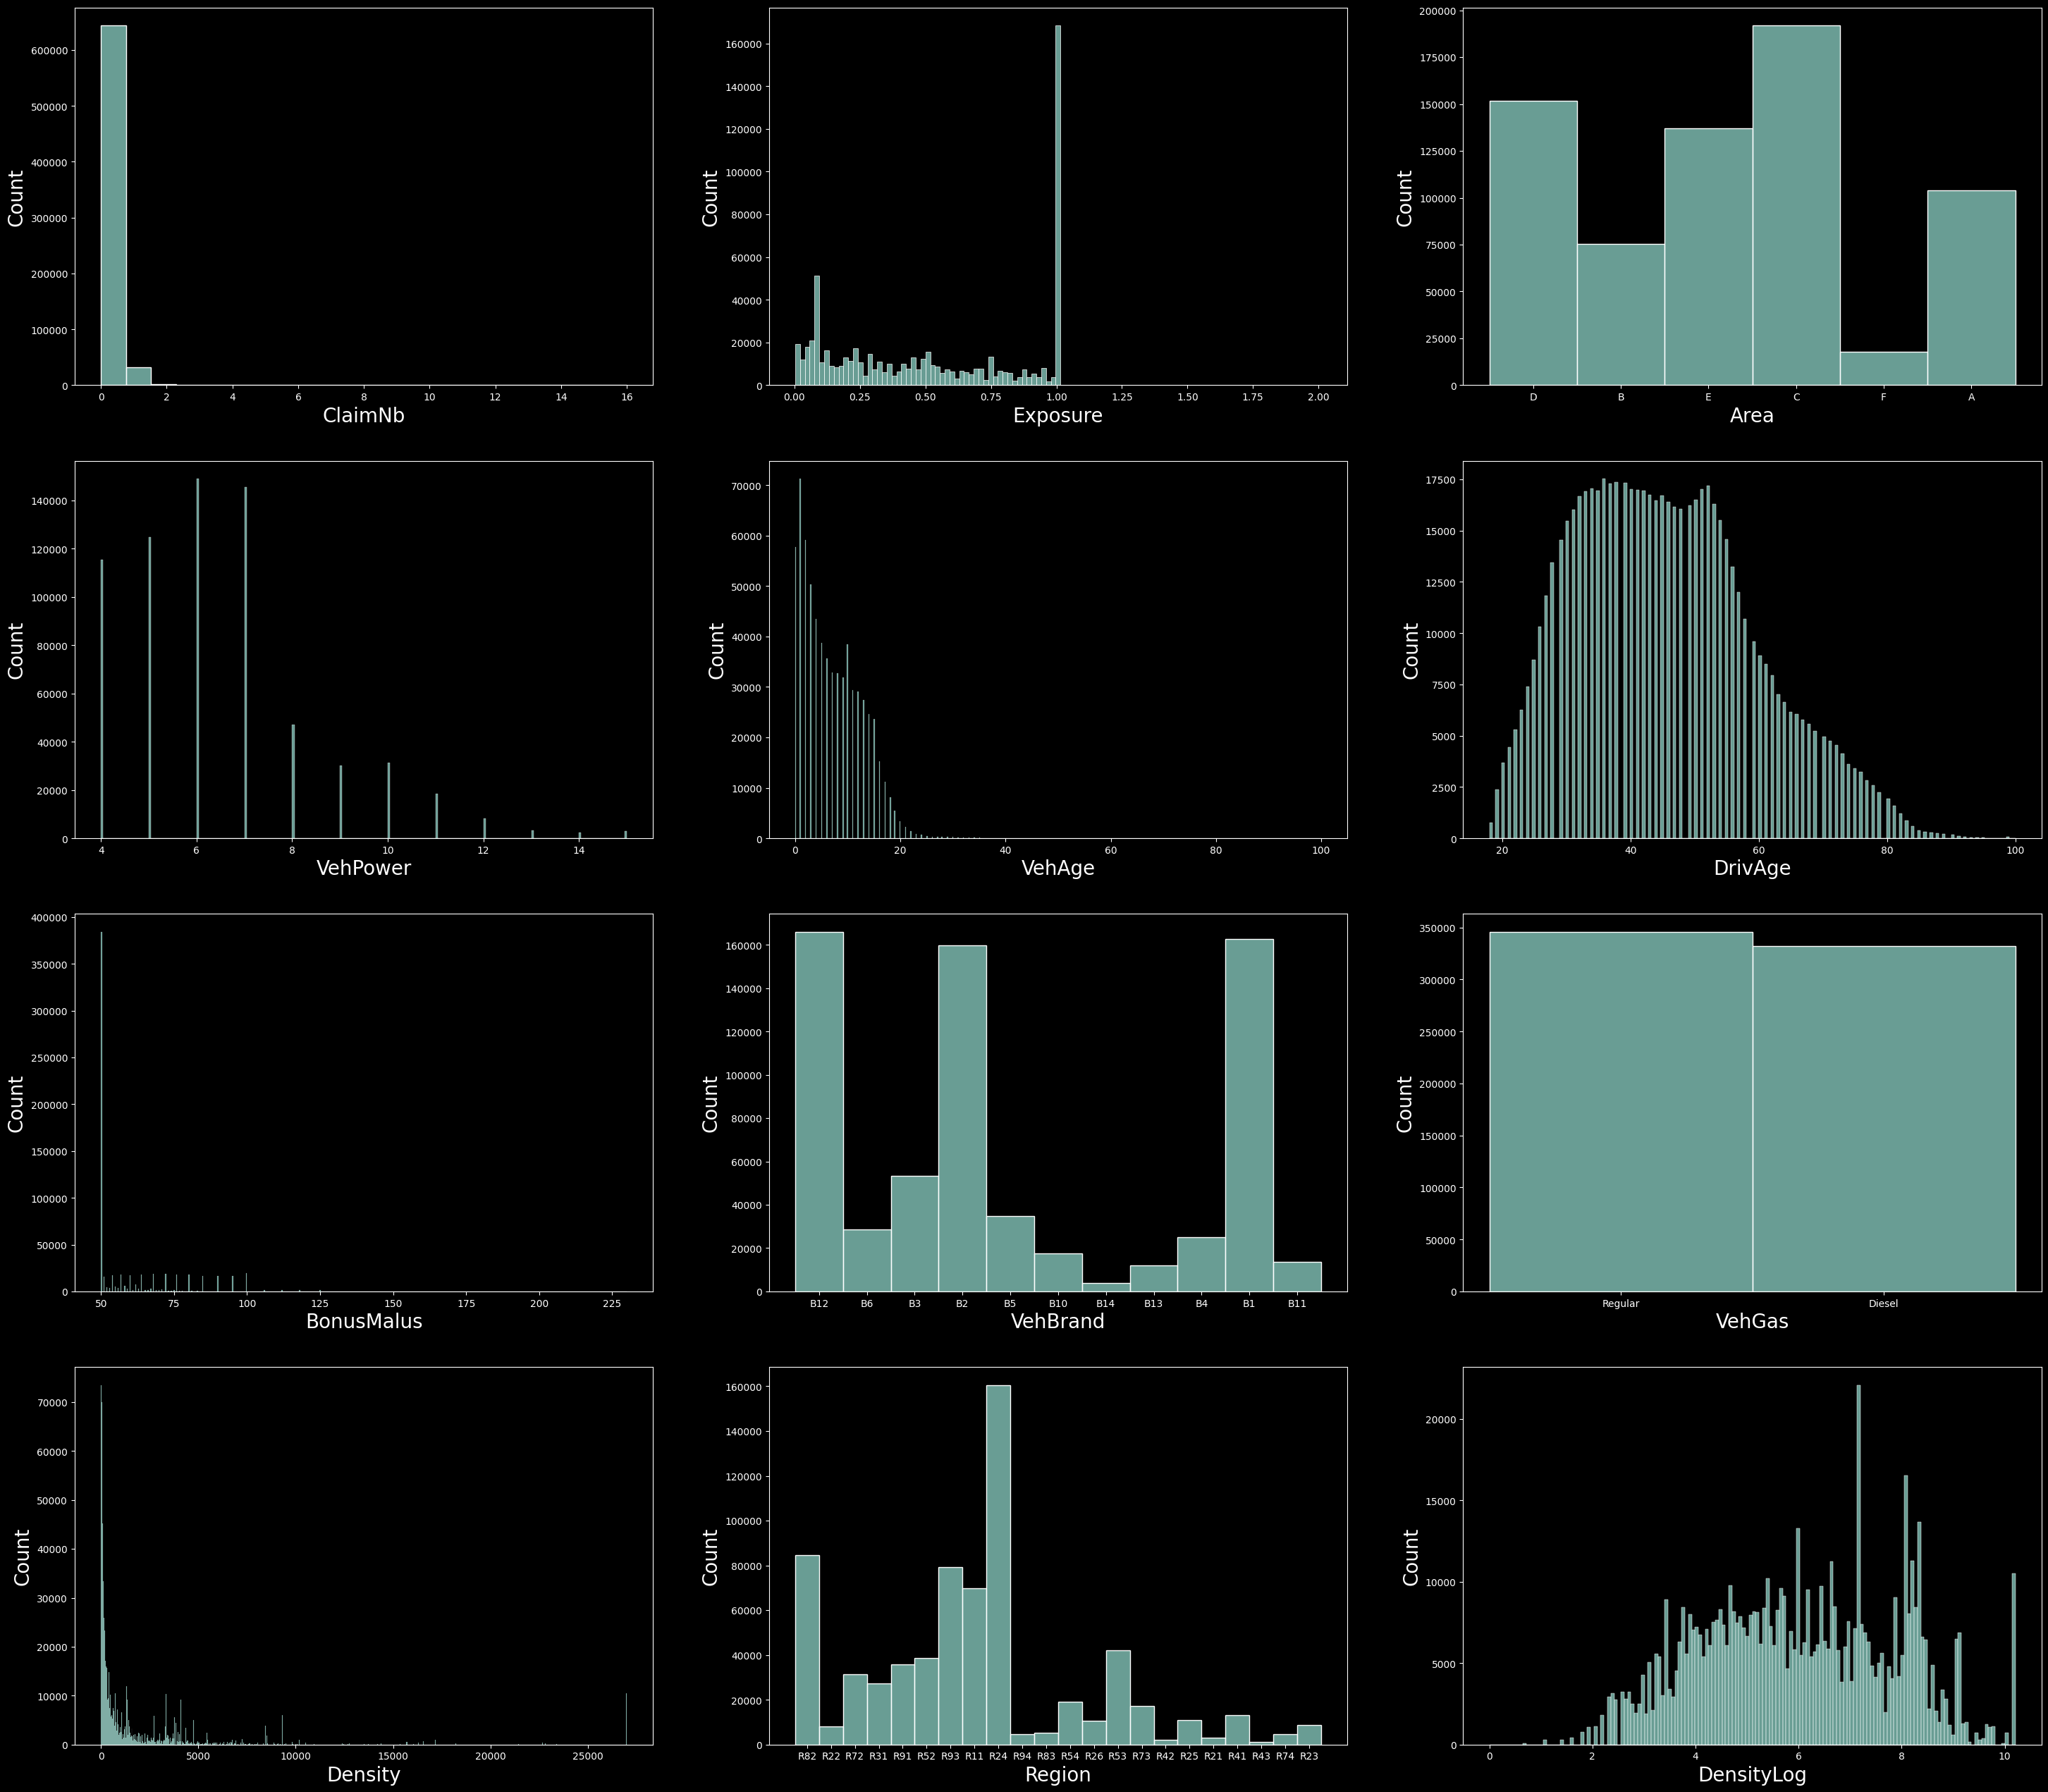

In [12]:
plot_hists(df.assign(DensityLog=np.log(df['Density'])), [col for col in df.columns if col not in ['IDpol']] + ['DensityLog'], 3)

In [13]:
df[['Exposure', 'ClaimNb', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']].quantile(0.995)

Exposure          1.0
ClaimNb           1.0
VehPower         14.0
VehAge           24.0
DrivAge          83.0
BonusMalus      118.0
Density       27000.0
Name: 0.995, dtype: float64

### b. Histogramy na zmodyfikowanych danych

In [14]:
from copy import deepcopy
df_mod = deepcopy(df)
df_mod.dropna(axis=0, how='any', inplace=True)
df_mod['Exposure'] = df_mod['Exposure'].clip(upper=1.0)
df_mod['ClaimNb'] = df_mod['ClaimNb'].clip(upper=4)
df_mod['VehPower'] = df_mod['VehPower'].clip(upper=14)
df_mod['VehAge'] = df_mod['VehAge'].clip(upper=21)
df_mod['DrivAge'] = df_mod['DrivAge'].clip(upper=90)
df_mod['BonusMalus'] = df_mod['BonusMalus'].apply(lambda x: 150 if x > 150 else round(x / 5) * 5)
df_mod['Density'] = df_mod['Density'].apply(lambda x: round(math.log(x), 1))

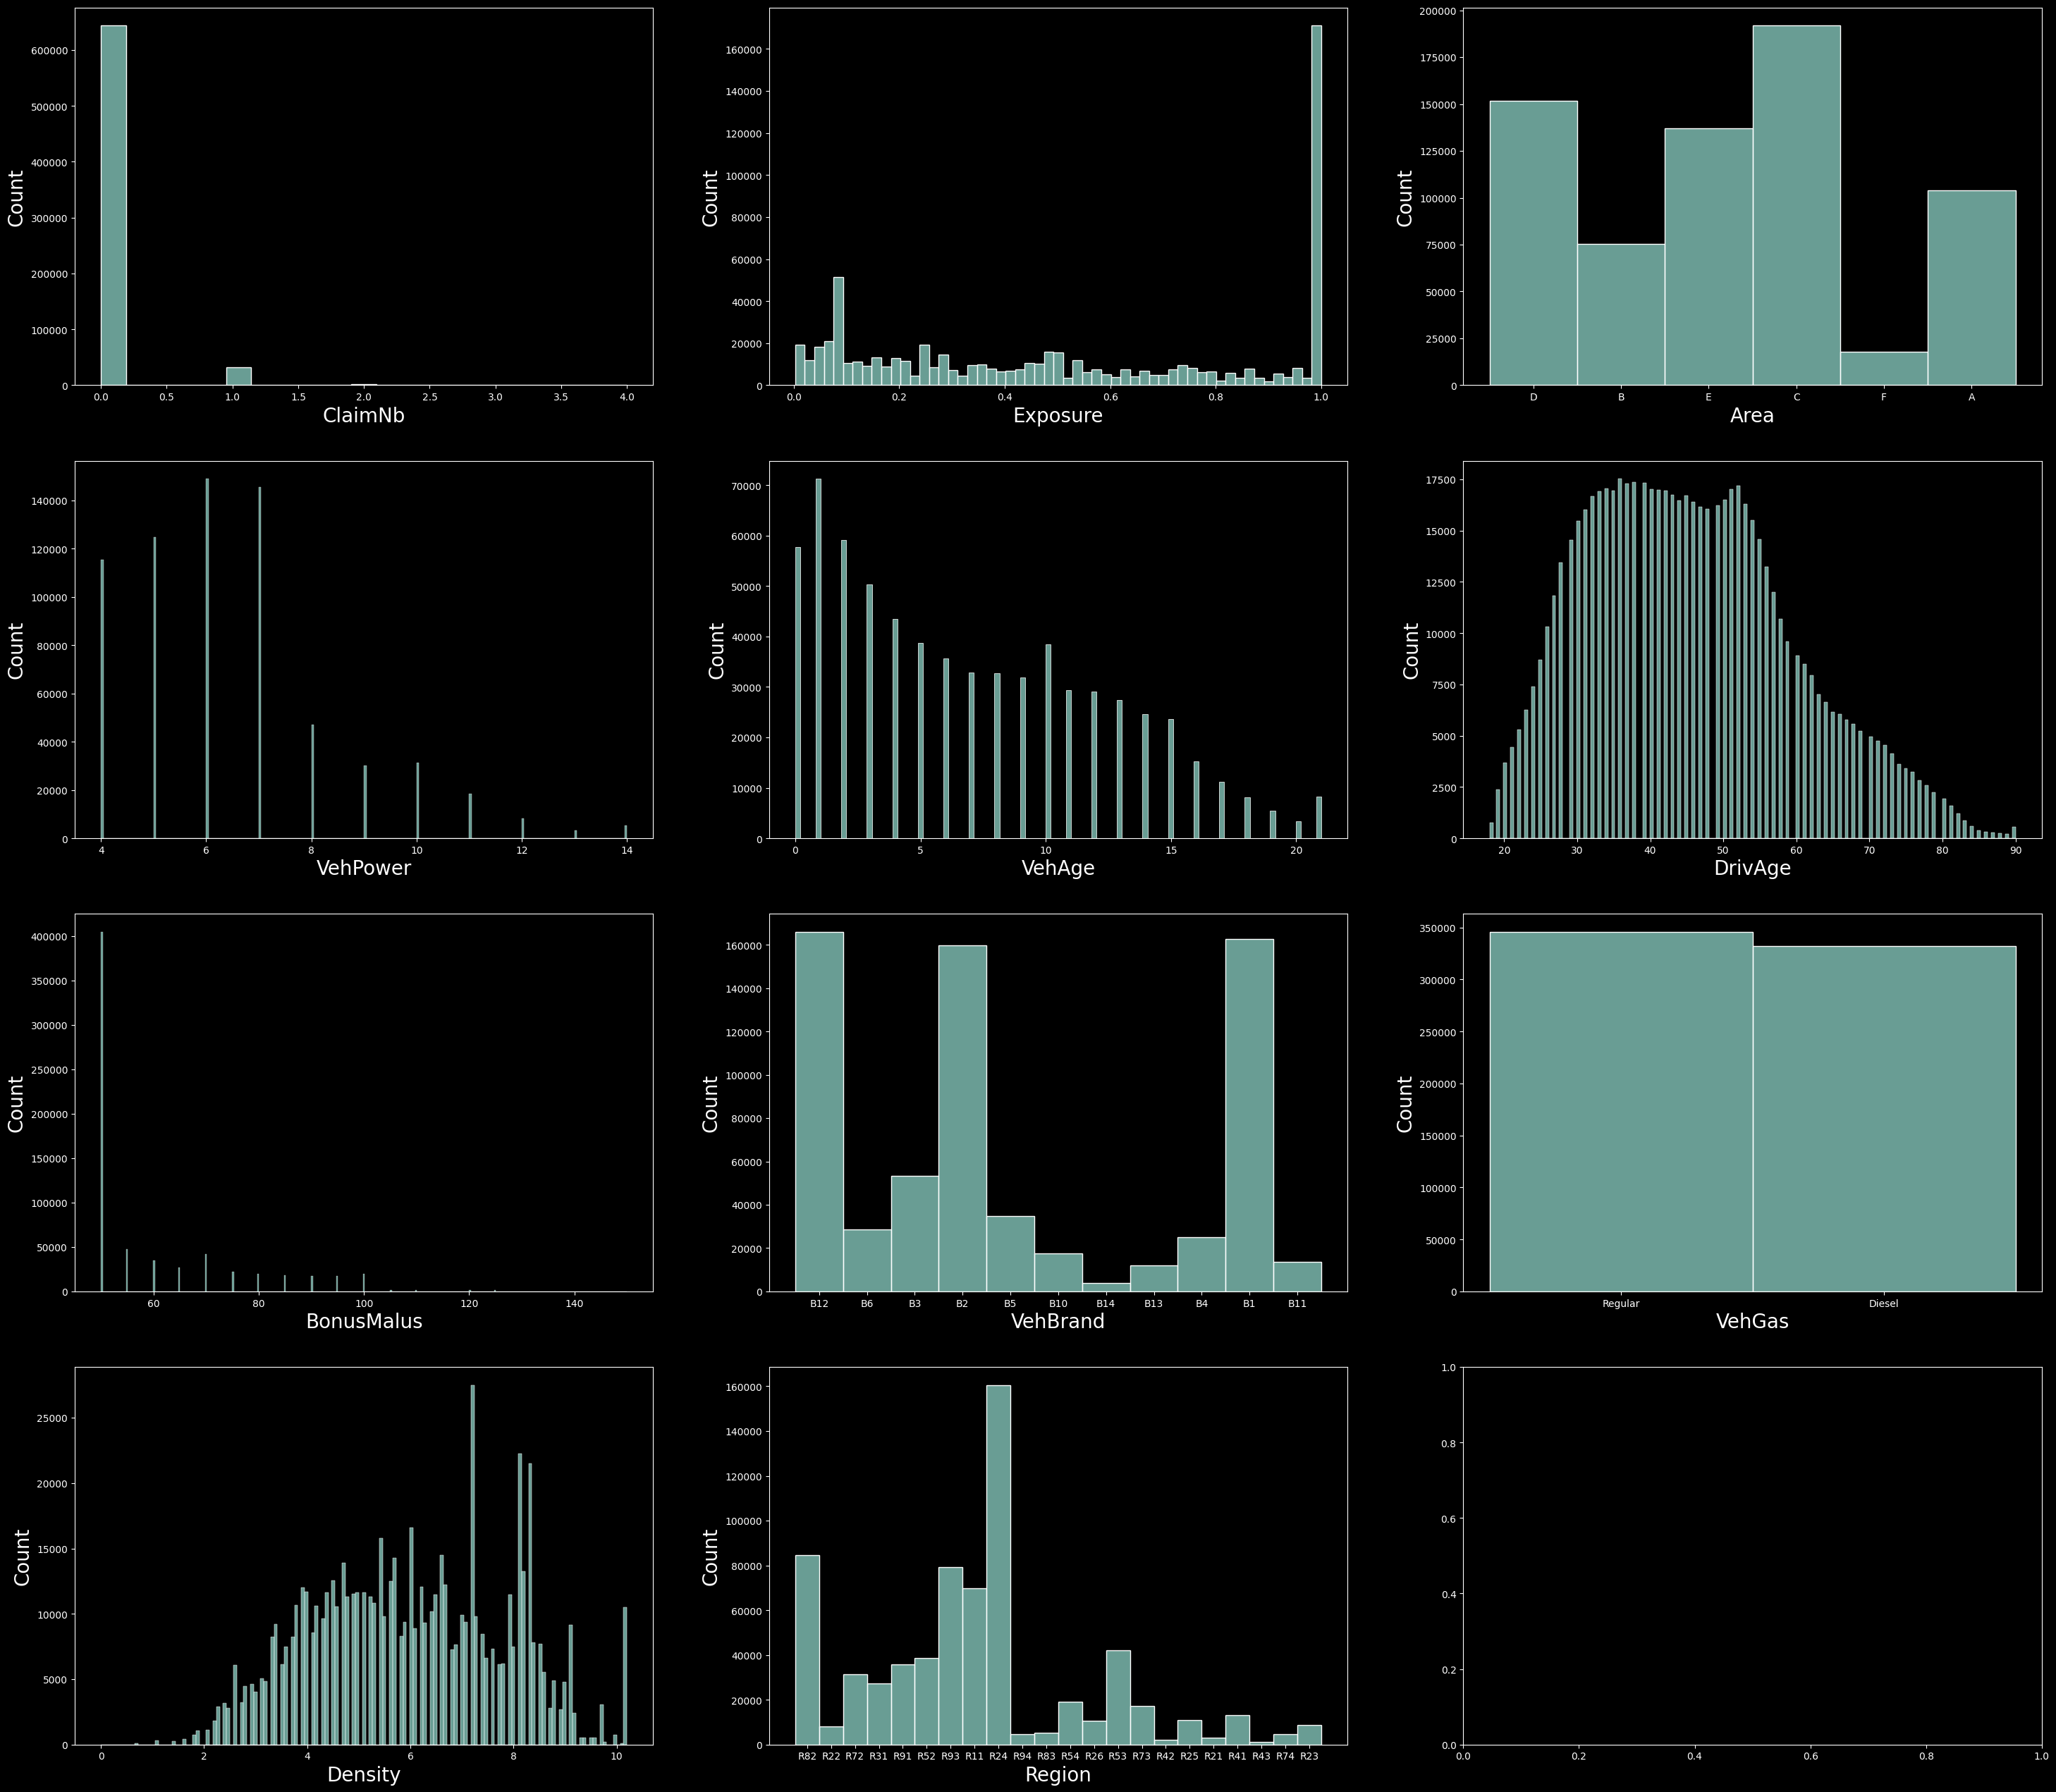

In [15]:
plot_hists(df_mod, [col for col in df_mod.columns if col not in ['IDpol']], 3)

### c. Częstość portfelowa vs częstość marginalna

W dalszej części używał zmodyfikowanego zbioru `df_mod`.

In [16]:
print(f"Liczba szkód w surowych danych: {int(df.ClaimNb.sum()):_}")
print(f"Liczba szkód w zmodyfikowanych danych: {int(df_mod.ClaimNb.sum()):_}\n")

print(f"Ekspozycja w surowych danych: {int(df.Exposure.sum()):_}")
print(f"Ekspozycja w zmodyfikowanych danych: {int(df_mod.Exposure.sum()):_}\n")

print(f"Częstość szkód w surowych danych dla całego portfela: {df.ClaimNb.sum() / df.Exposure.sum():.3%}")
print(f"Częstość szkód w zmodyfikowanych danych dla całego portfela: {df_mod.ClaimNb.sum() / df_mod.Exposure.sum():.3%}")

Liczba szkód w surowych danych: 36_101
Liczba szkód w zmodyfikowanych danych: 36_053

Ekspozycja w surowych danych: 358_498
Ekspozycja w zmodyfikowanych danych: 358_352

Częstość szkód w surowych danych dla całego portfela: 10.070%
Częstość szkód w zmodyfikowanych danych dla całego portfela: 10.061%


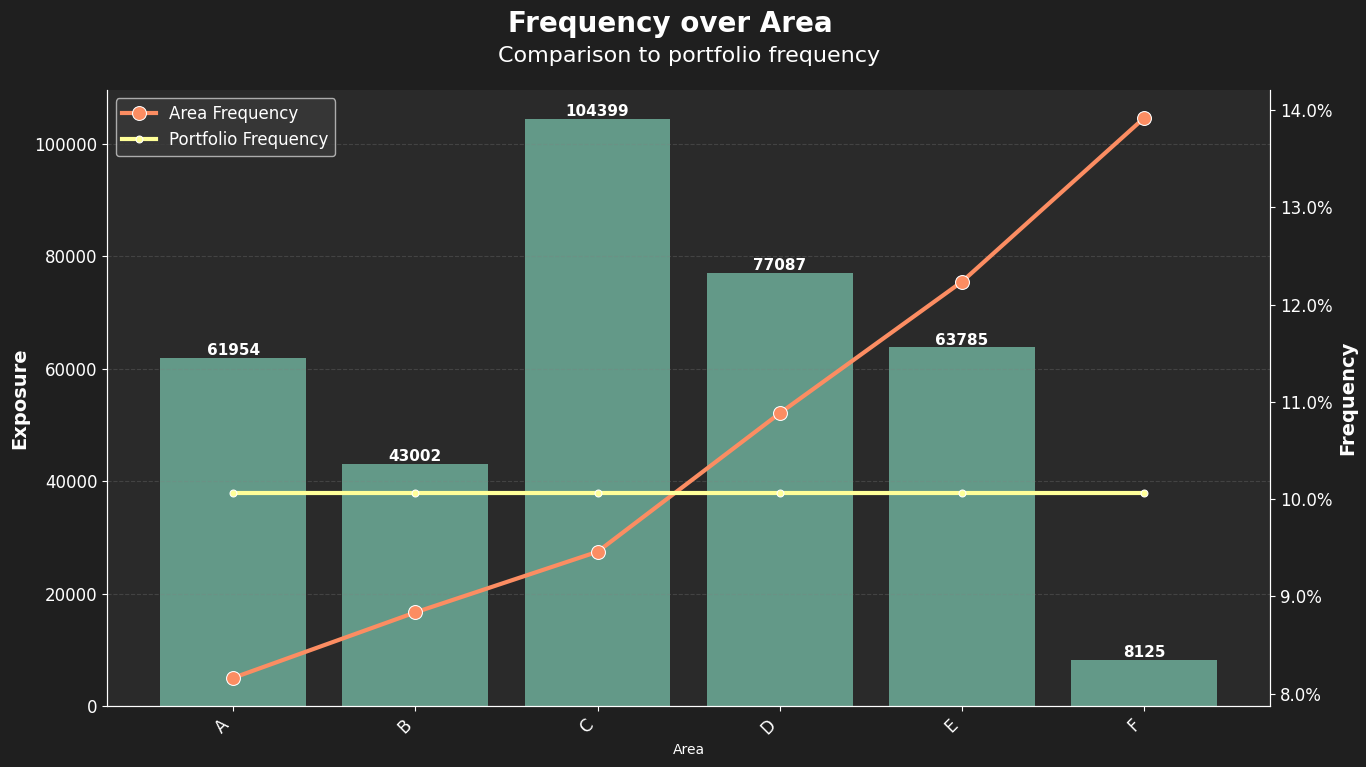

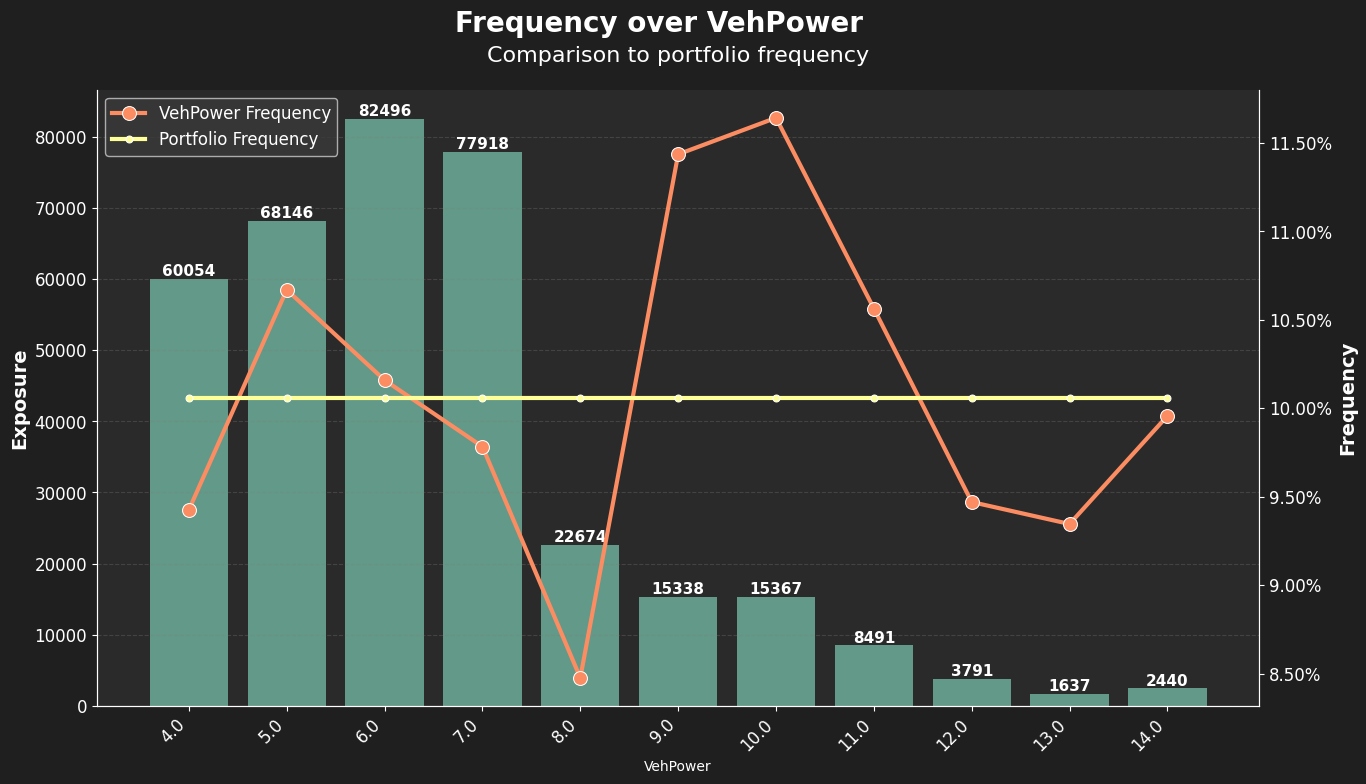

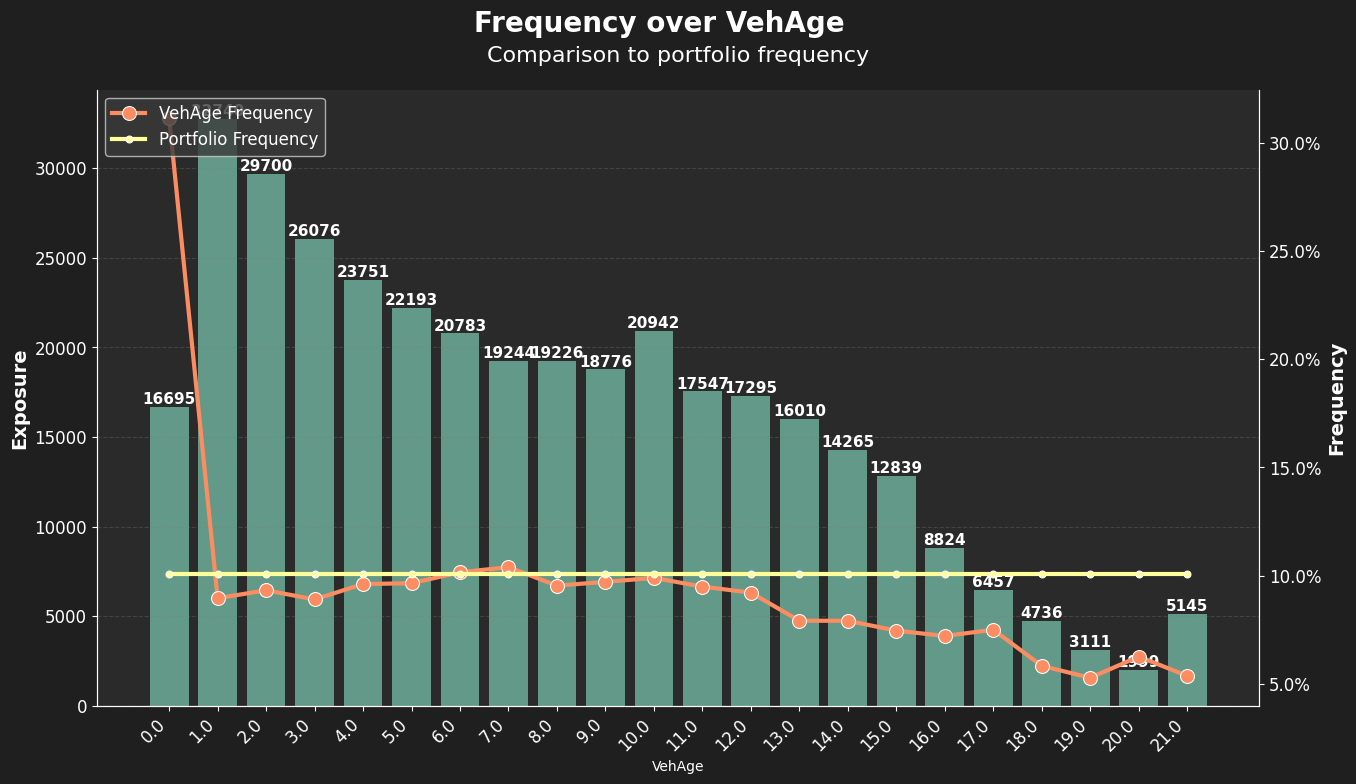

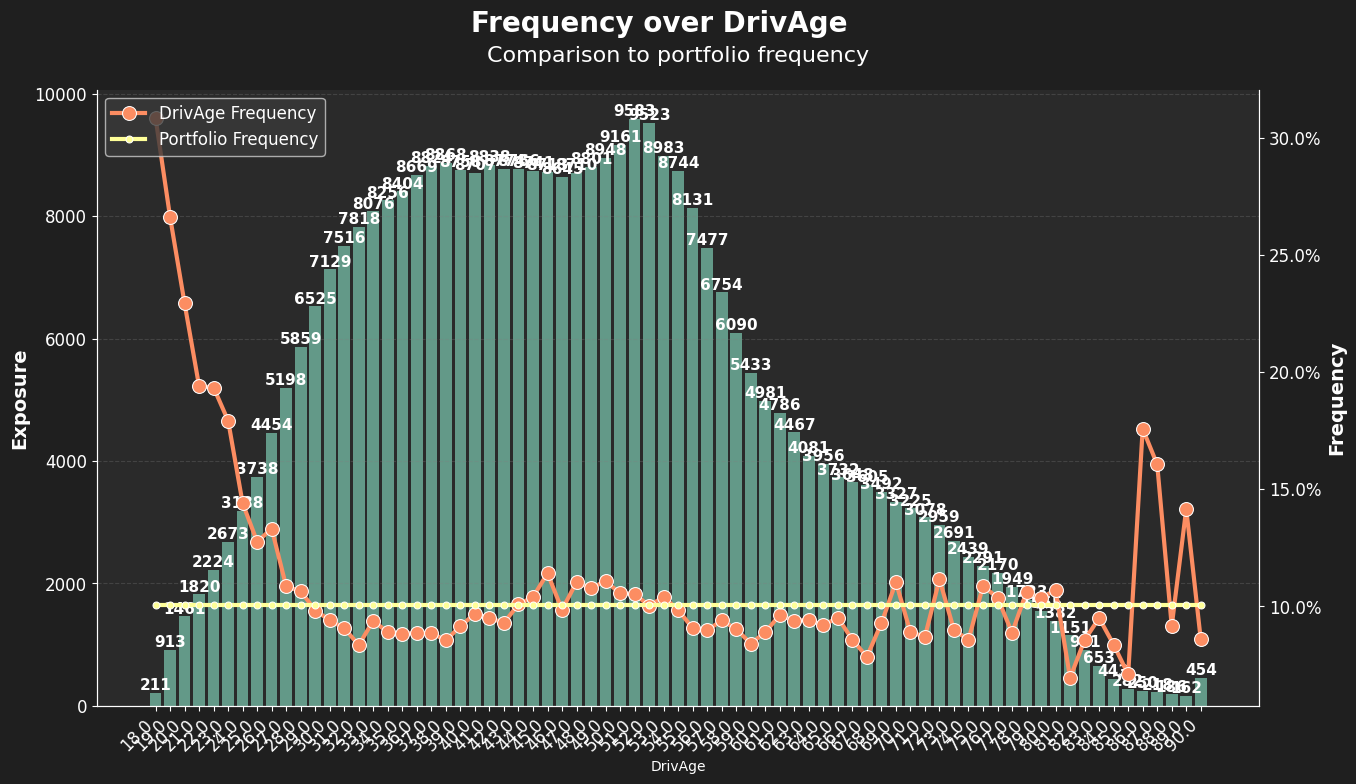

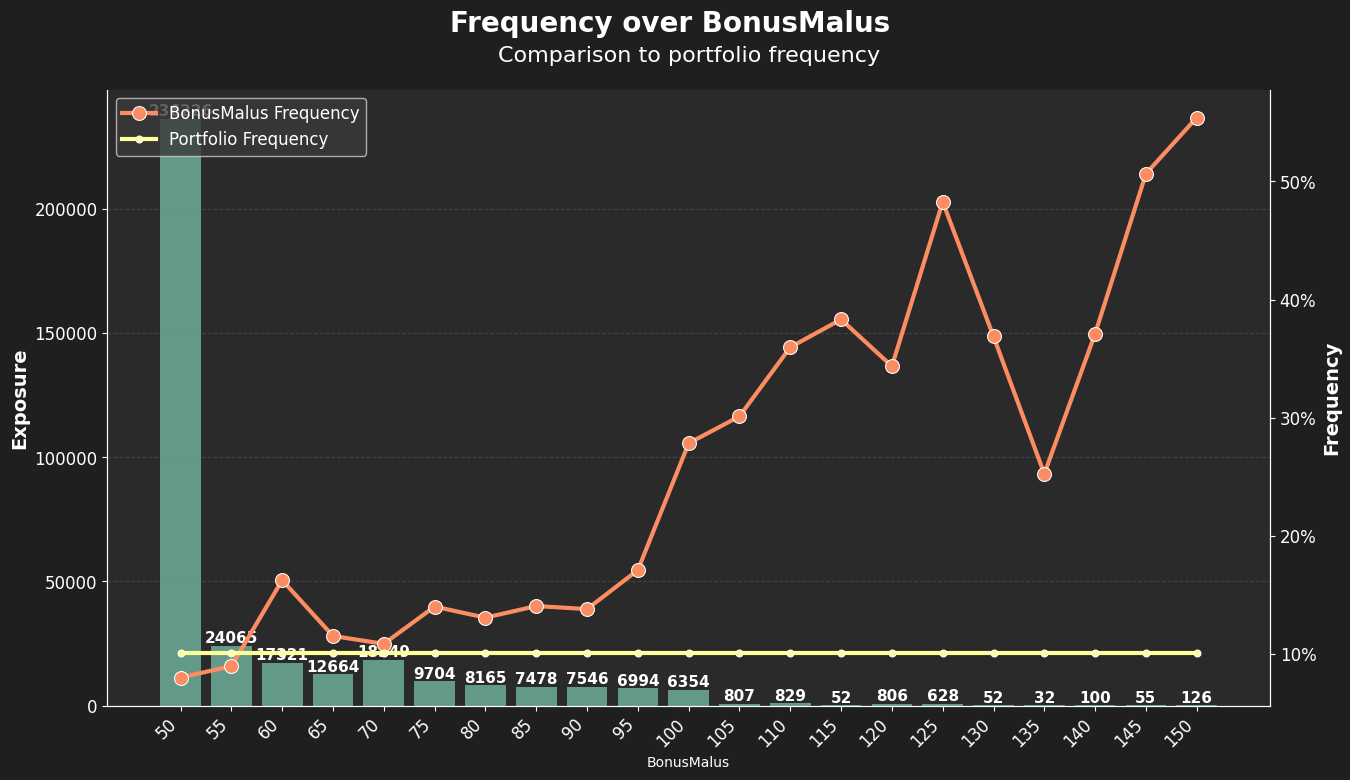

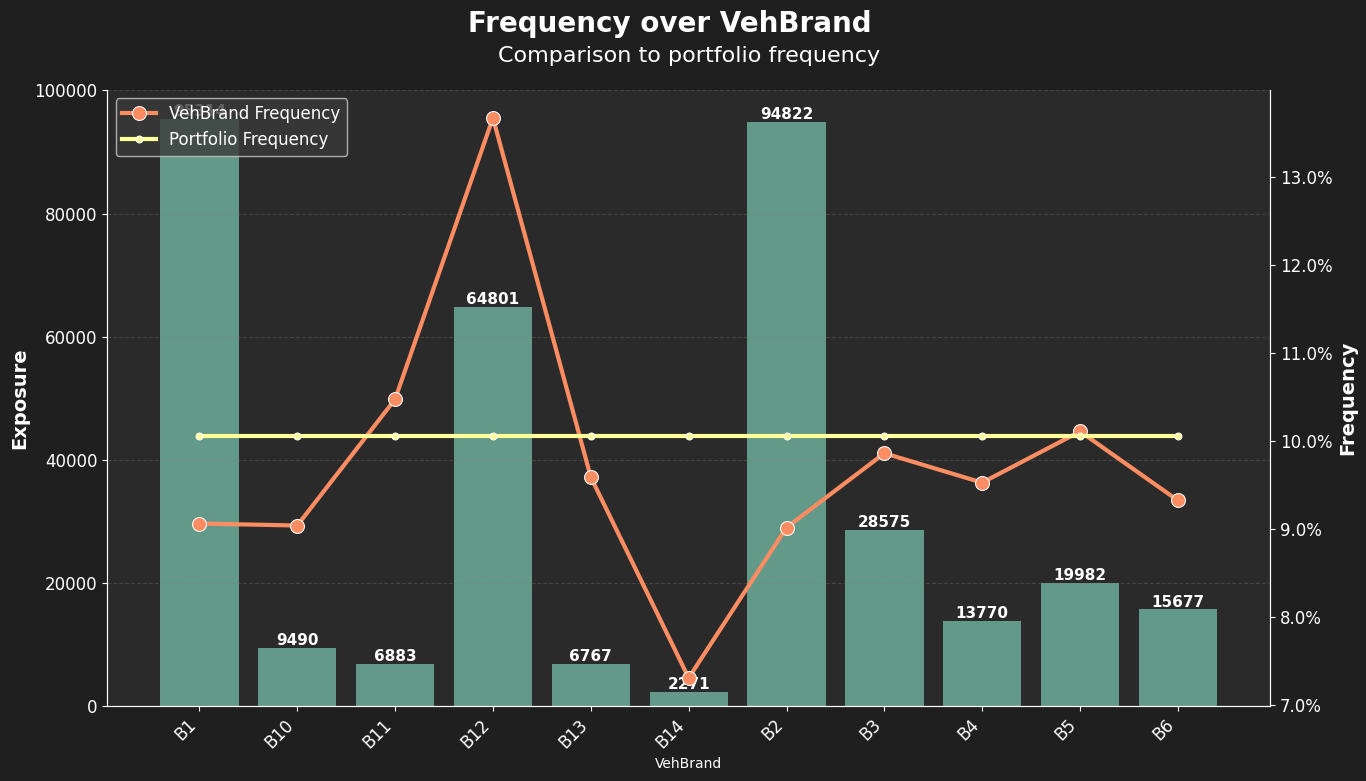

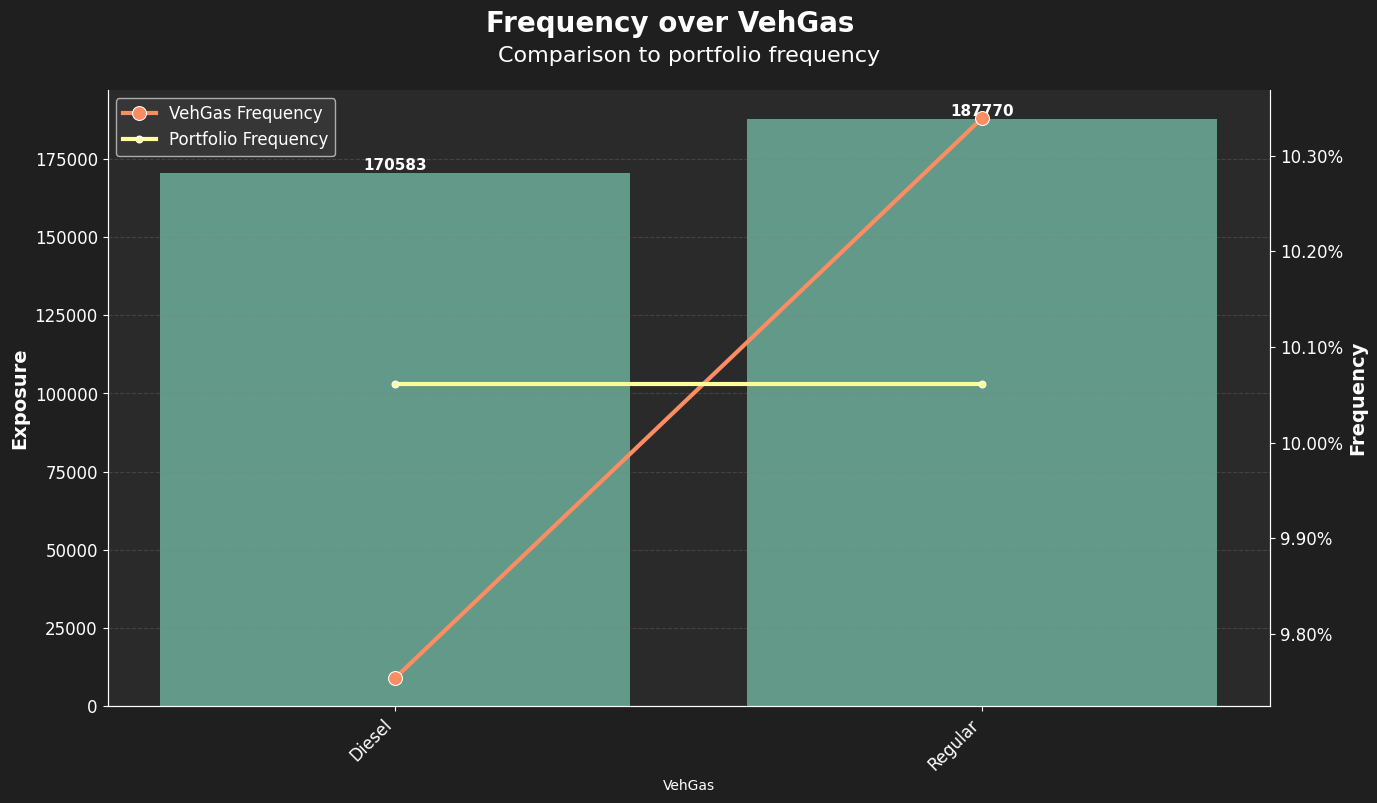

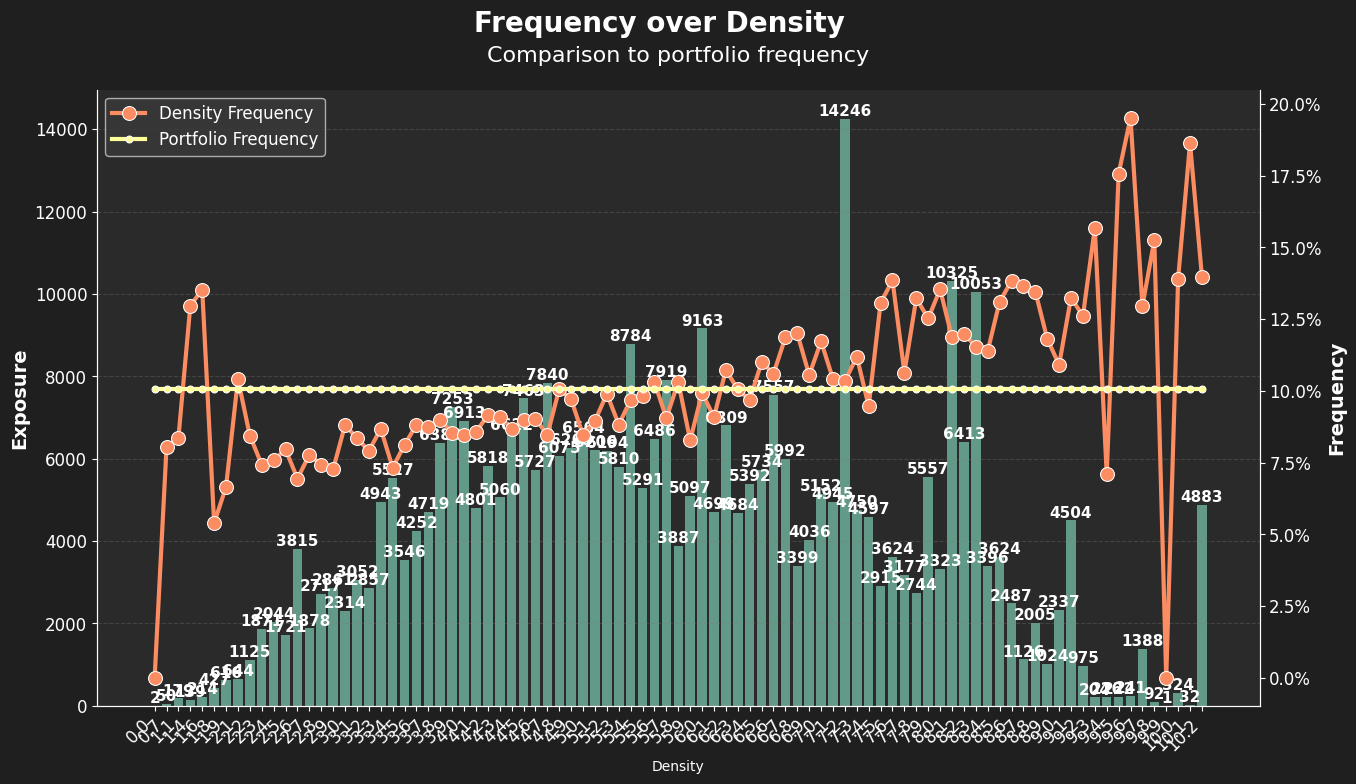

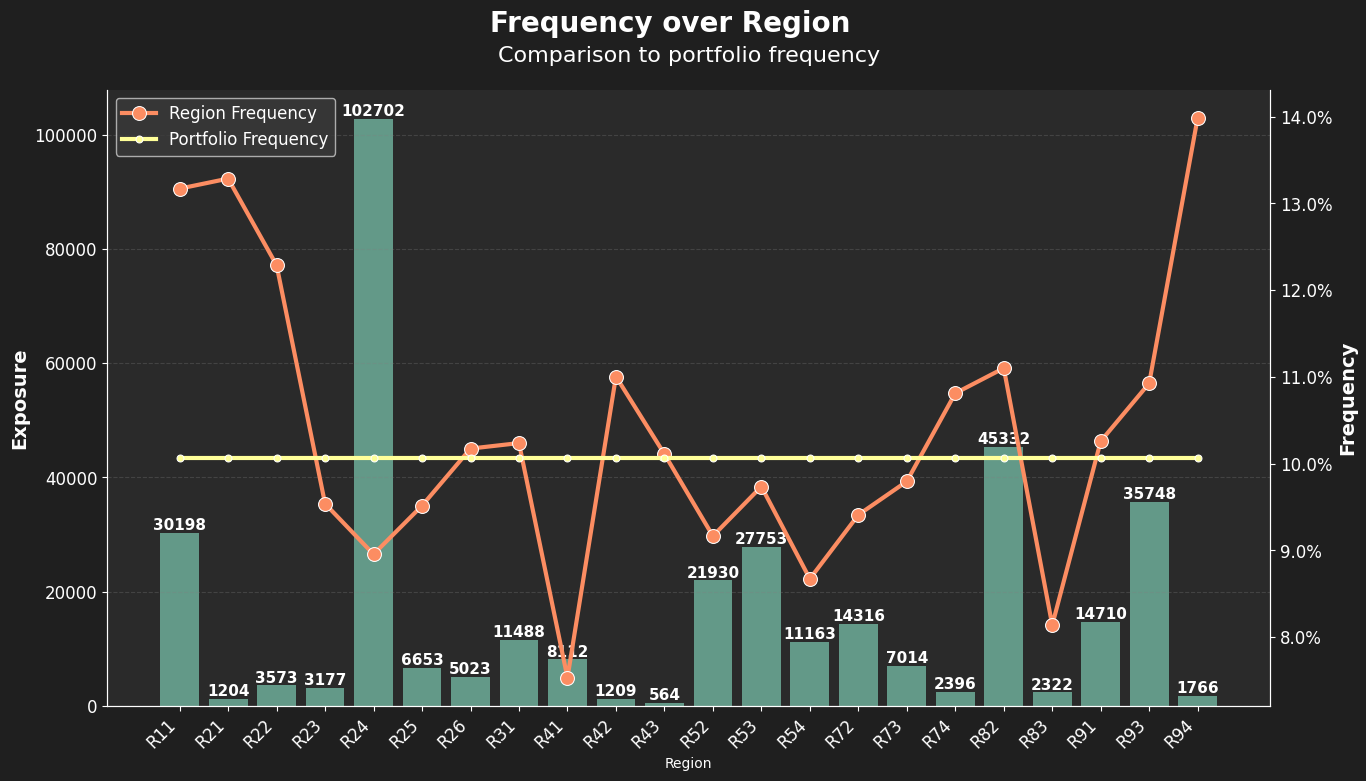

In [17]:
for attribute in [col for col in df_mod.columns if col not in ['IDpol', 'ClaimNb', 'Exposure']]:
    fig, ax1, ax2 = freq_over_attribute_plot(df_mod, attribute)
    plt.show()

### d. Korelacje pomiędzy zmiennymi
Analizując wykresy korelacji Pearsona i Spearmana, można zauważyć:
- Korelacje Spearmana są generalnie silniejsze niż Pearsona, co wskazuje na nieliniowy charakter niektórych zależności
- Jest widoczna silna zależność `BonusMalus` i `DrivAge`, która wydaje się intuicyjna - im starszy kierowca tym niższa wartość BonusMalus.


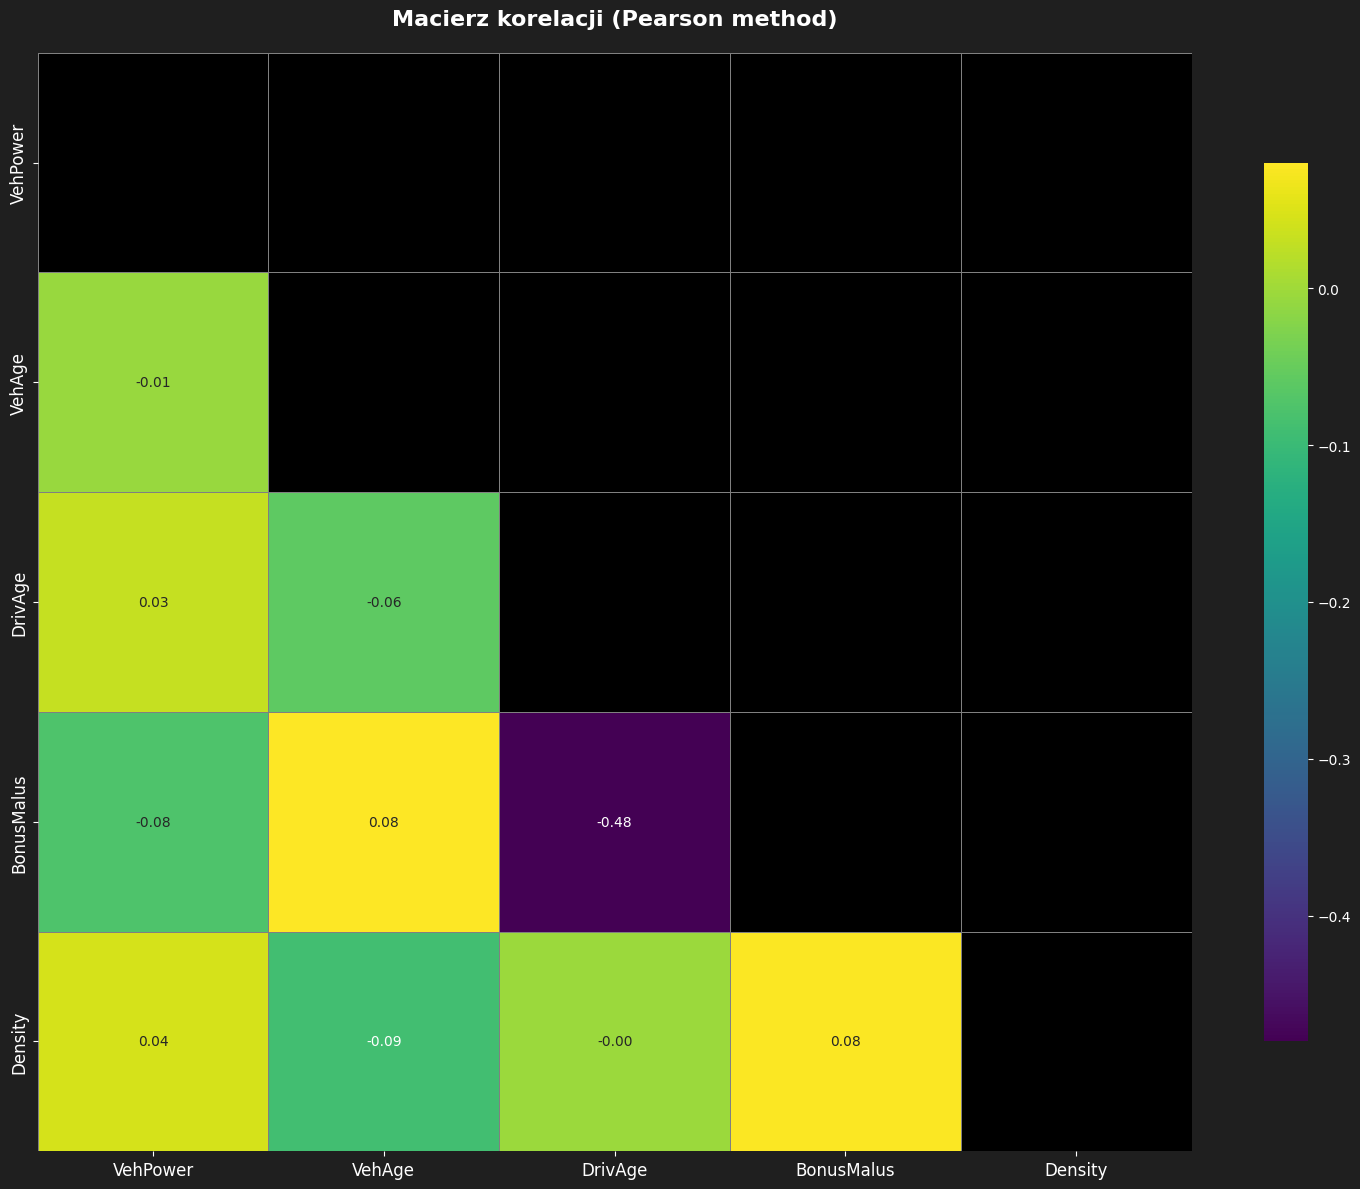

In [18]:
corr_plot(df[['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']], method='pearson')

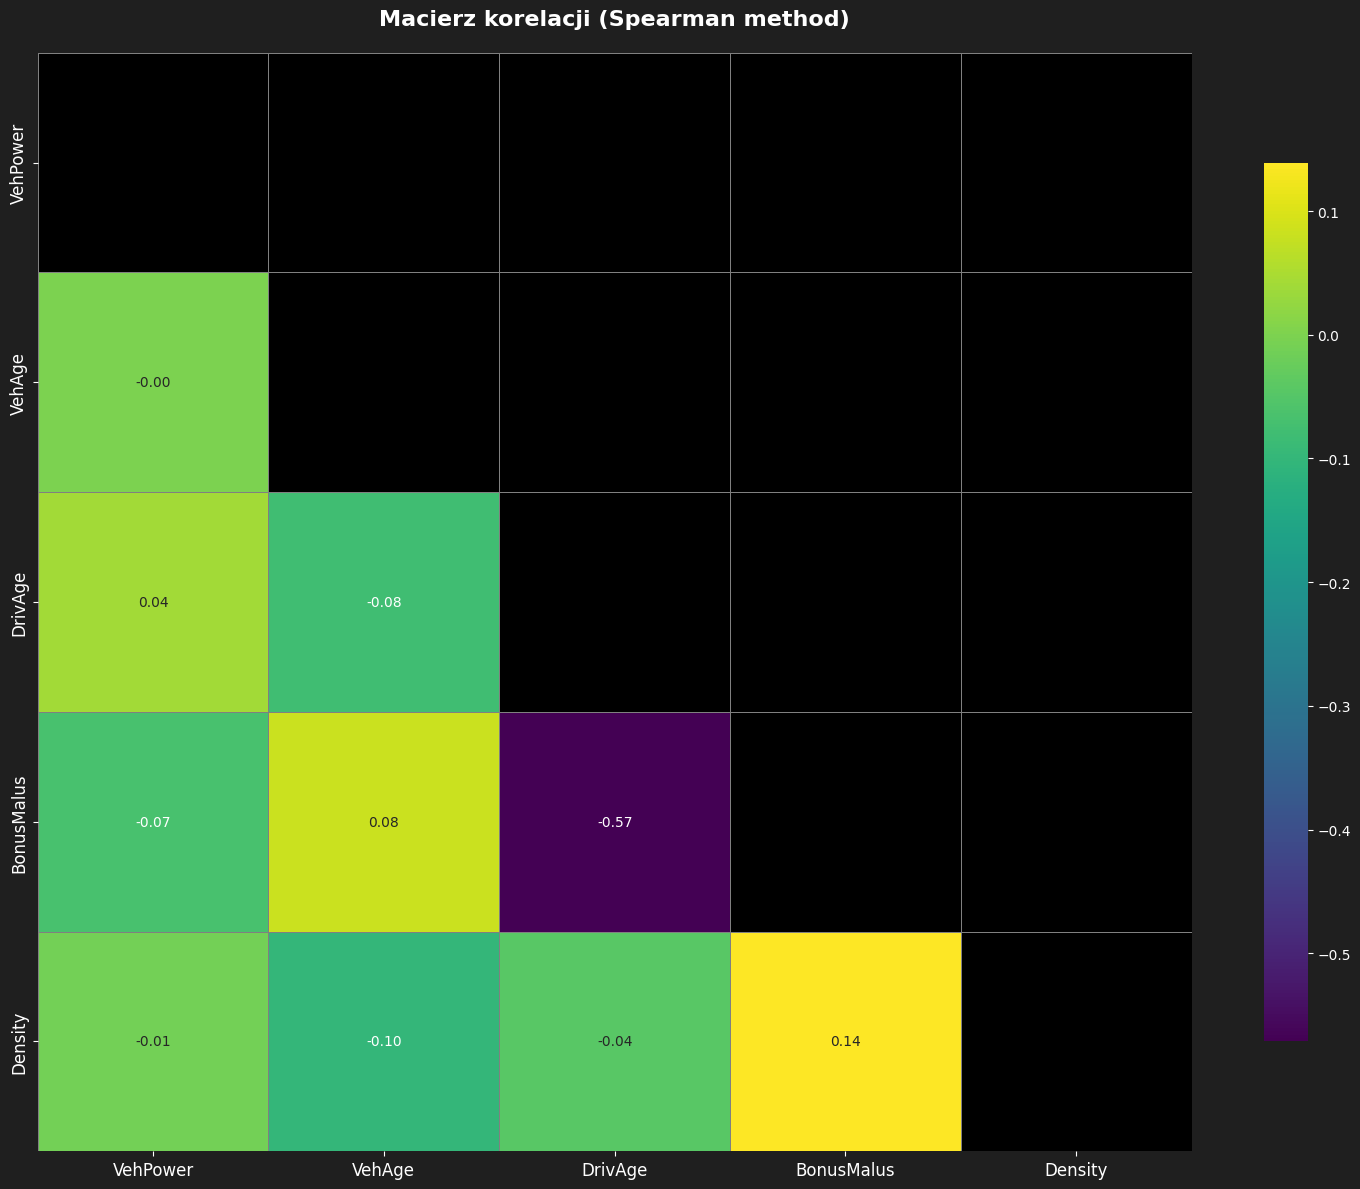

In [20]:
corr_plot(df[['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']], method='spearman')

Poniżej wykres punktowy wraz z linią trendu dla zmiennych najsilniej ze sobą skorelowanych - `DrivAge` i `BonusMalus`. 

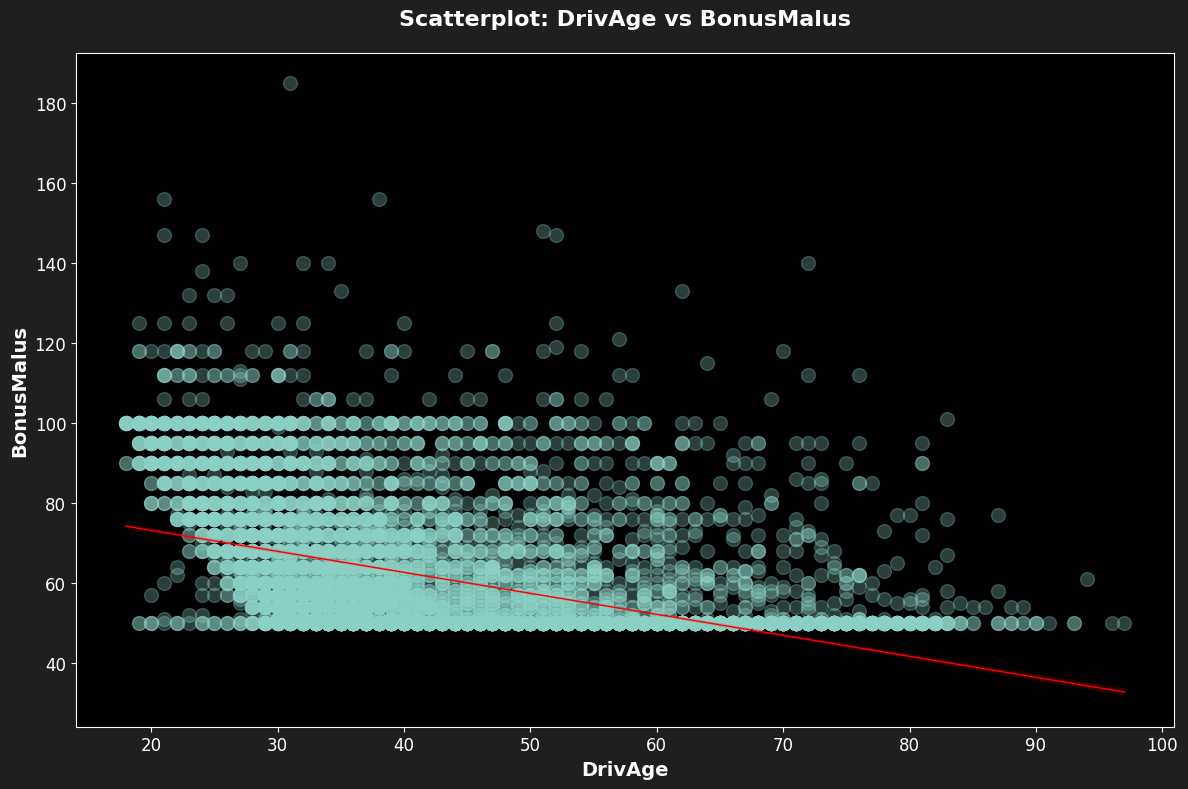

In [30]:
scatter_plot(df.sample(n=10000), 'DrivAge', 'BonusMalus', trendline=True)

### e. Rozkład `Exposure`, `ClaimNb` lub `Frequency` dla dwóch wymiarów atrybutów
Z poniższych wykresów widać, że:
- młodsi kierowcy jeżdżą nowszymi pojazdami
- 10-letnia auta są nadreprezentowane (co widać też na histogramach prezentowanych wcześniej)
- młodsi kierowcy jeżdżą mocniejszymi pojazdami

(np.float64(0.0081967213114754), np.float64(916.9403585596081))

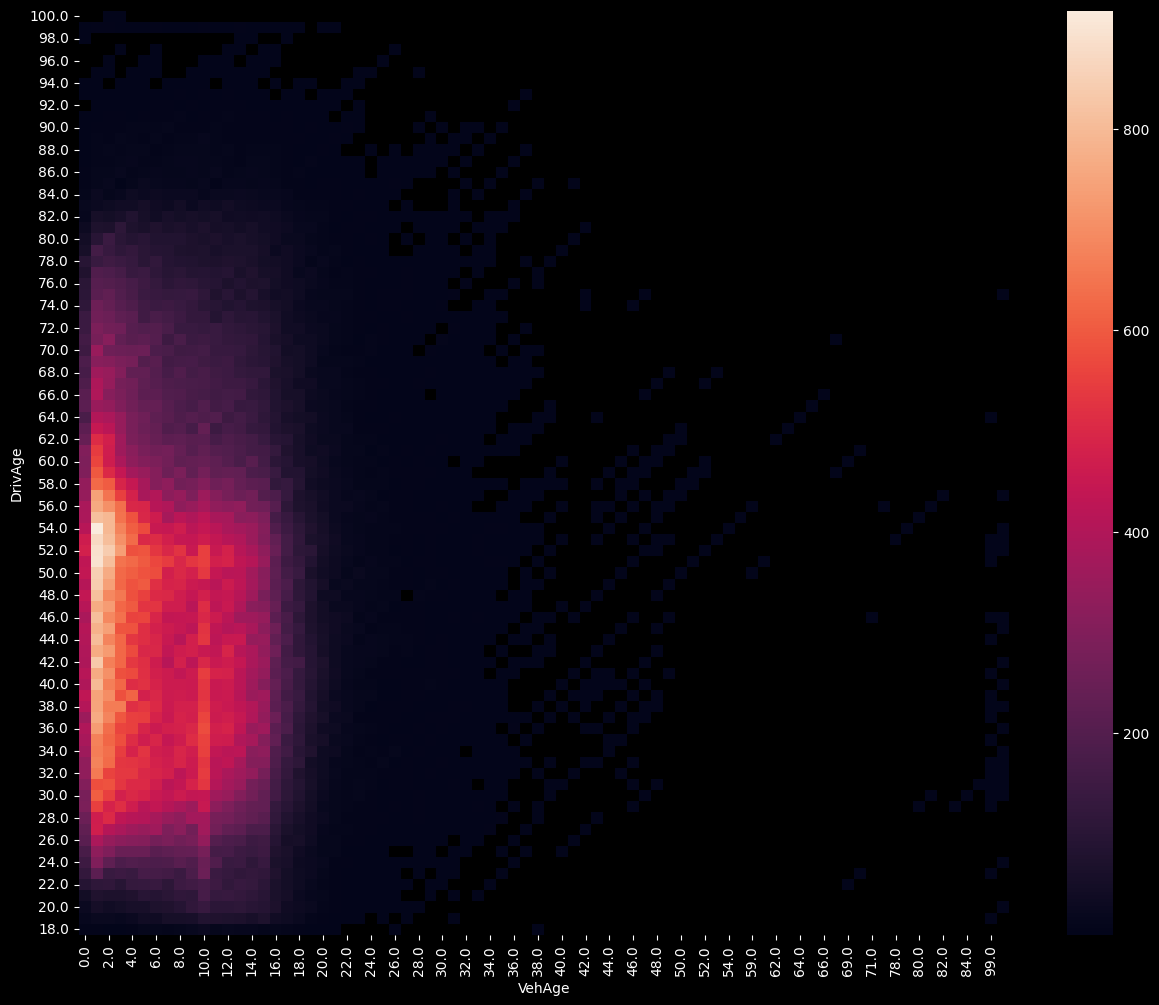

In [31]:
plot_heatmap(df, 'DrivAge', 'VehAge', 'Exposure', 0.0, 1.0)

(np.float64(0.03), np.float64(2141.946014670571))

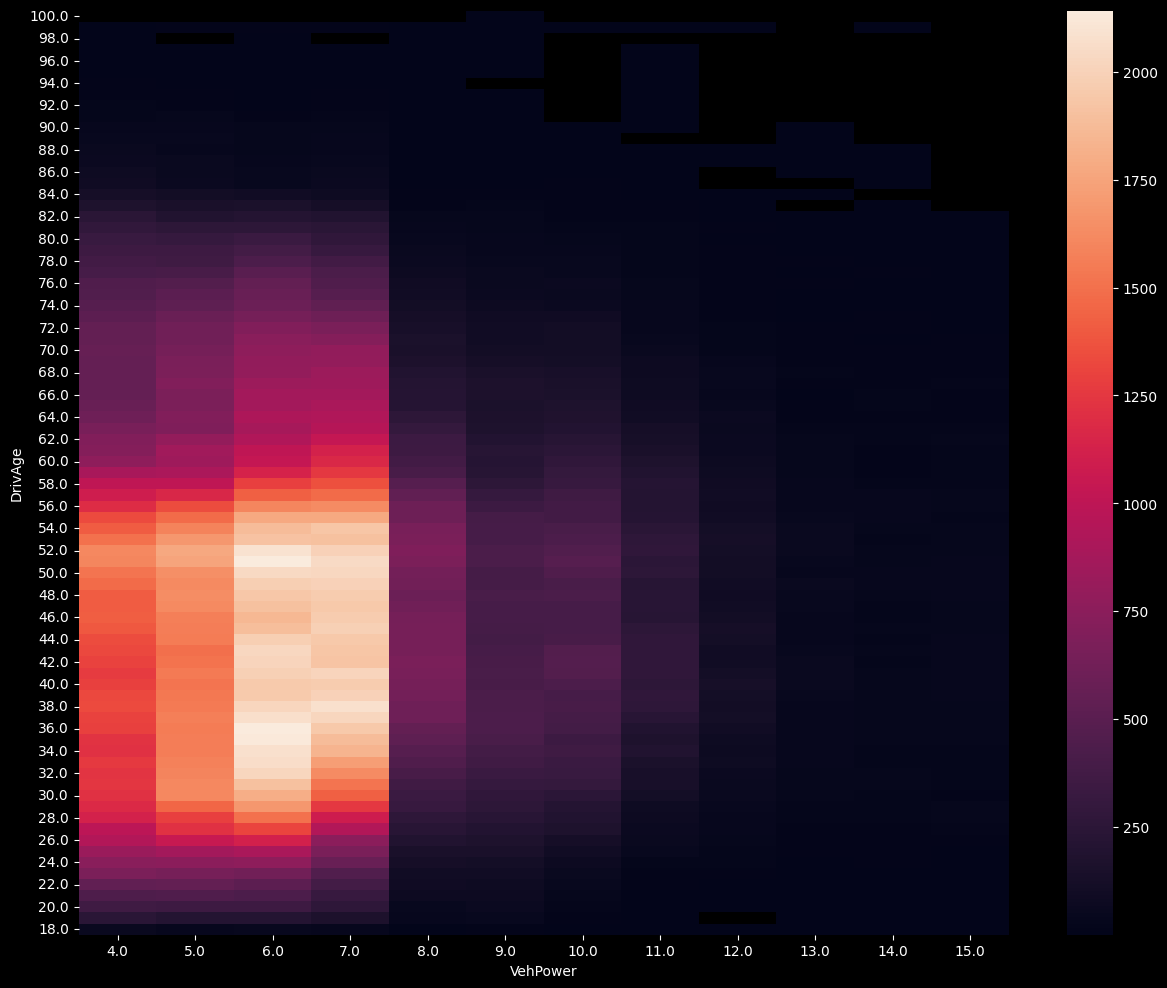

In [54]:
utils.plot_heatmap(df, 'DrivAge', 'VehPower', 'Exposure', 0.0, 1.0)

(np.float64(0.04), np.float64(53501.07674599234))

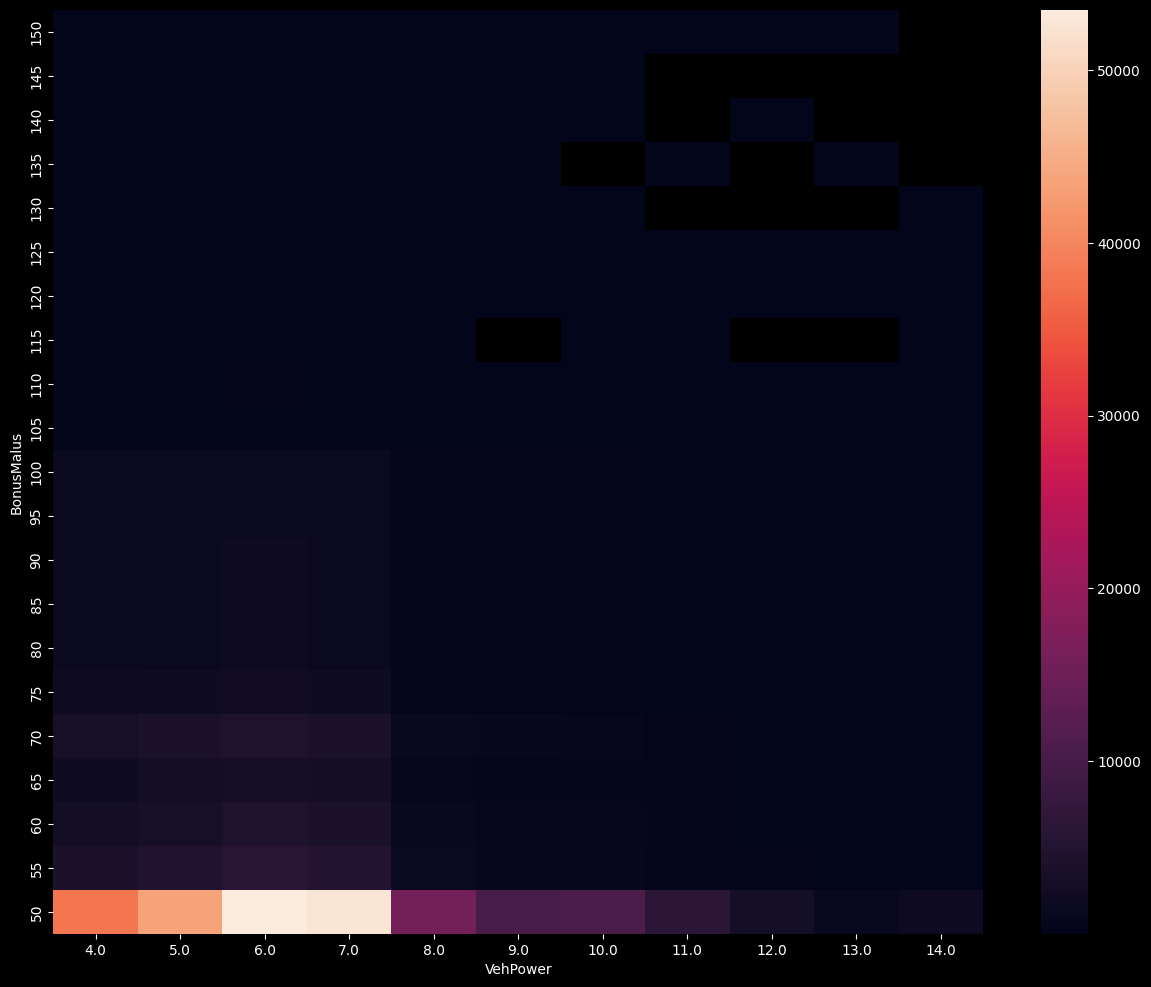

In [32]:
plot_heatmap(df_mod, 'BonusMalus', 'VehPower', 'Exposure', 0.0, 1.0)

Wysoka częstość dla nowych samochodów i młodych kierowców.

(np.float64(0.0), np.float64(0.4413464940945919))

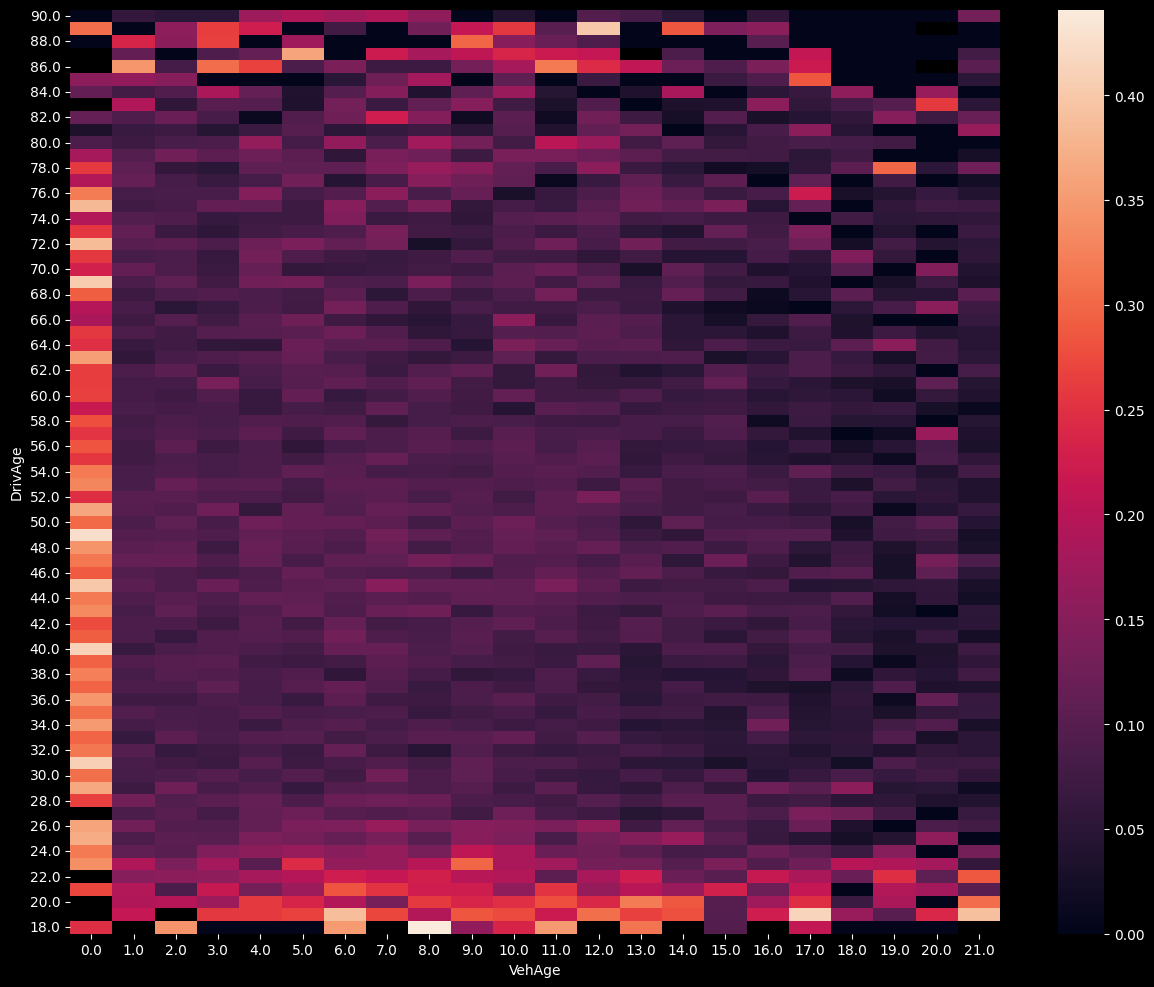

In [33]:
plot_heatmap(df_mod, 'DrivAge', 'VehAge', 'Freq', 0.01, 0.99)

(np.float64(0.04), np.float64(1257.5022164828326))

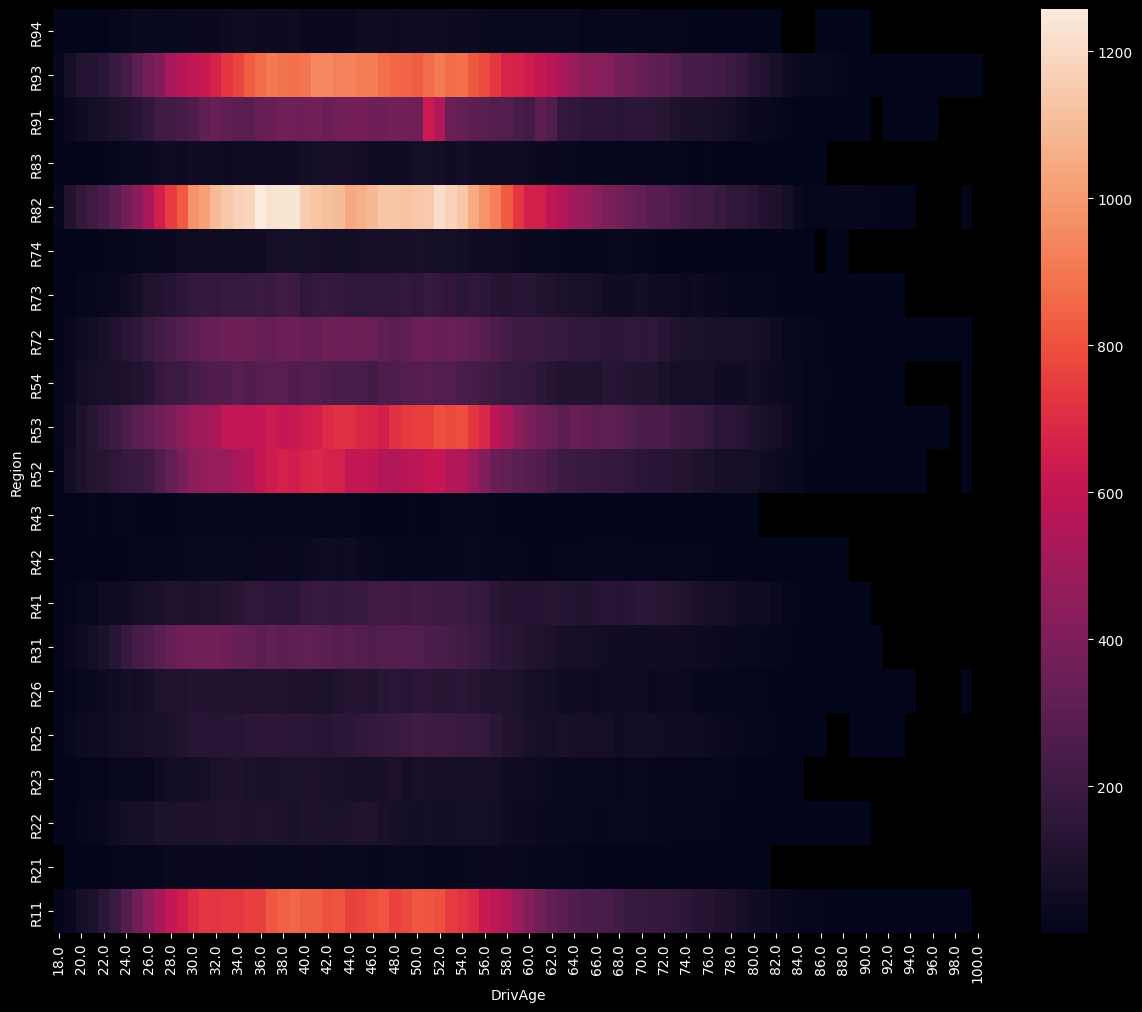

In [72]:
utils.plot_heatmap(df[df['Region'] != 'R24'], 'Region', 'DrivAge', 'Exposure', 0, 1)